# Agent-Based SIS Model on Networks

In this coding activity, we'll implement an agent-based model of the spread of infectious disease on networks. You can learn more about the theory of models like these from the [lecture notes](http://www.philchodrow.com/intro-networks/chapters/multi_agent_models.html#epidemic-modeling) and in Newman, Chapter 14. 

We're going to focus on the **SIS model**. 

The SIS model is one of many *compartmental* models of spreading processes on networks. Unlike the opinion models we studied above, in which each agent's state is a continuous variable $x_i \in [-1, 1]$, in compartmental models, each agent can be in one of several *discrete* states, called compartments. Think of each compartment as a qualitative status. In the SIS model, there are two compartments: 

- **Susceptible (S)**: The agent is not currently infected with disease, but you could be in the future. 
- **Infected (I)**: The agent is currently infected with disease, and can spread it to others. 

Modern compartmental models include many more compartments than this. One can also include compartments for **Immune**, **Infected (pre-symptomatic)**, etc. etc. Unfortunately for us, the model above in which immunity is never guaranteed seems like a more relevant one at the moment. 

![](https://noduslabs.com/wp-content/uploads/2012/02/Figure1-SIRS-510x329.png)

"SIS" stands for "Susceptible-Infected-Susceptible." This means that an agent who recovers from an infection is again susceptible. We'll consider a stochastic SIS model with the following transition rules. 

1. If agent $i$ is currently *Susceptible*, then for each *Infected* neighbor of $i$, agent $i$ flips a coin with probability of heads $\beta$. If any of these coins come up heads, then $i$ also becomes *Infected*. 
2. Additionally, if agent $i$ is currently *Susceptible*, then they also flip a coin with probability of heads $\beta_\mathrm{background}$, and become *Infected* if *this* coin comes up heads. The background infection rate models contacts with people outside the network data. 
2. If $i$ is currently *Infected*, then $i$ flips a coin with probability of heads $\gamma$. If this coin comes up heads, then $i$ recovers and is now *Susceptible* again. 

Ok, let's code it up! 


In [1]:
from mesa import Model, Agent                 # core mesa classes
from mesa.space import NetworkGrid             
from mesa.time import SimultaneousActivation           
from mesa.datacollection import DataCollector

import networkx as nx                         # for the grid
import numpy as np                            # computations
import seaborn as sns                         # install the seaborn package in your Python environment if this line doesn't run. 
from matplotlib import pyplot as plt

Epidemic models and opinion models are relatively similar, and so the `CompartmentalModel` of epidemic spread is *extremely* similar to the `OpinionModel` that we created previously. 

In [2]:
class CompartmentalModel(Model):

    # model setup
    def __init__(self, G, agent_class, p_infected = 0, beta = 0, beta_background = 0, **kwargs):

        self.schedule = SimultaneousActivation(self) 
        self.grid = NetworkGrid(G)            
        self.beta = beta
        self.beta_background = beta_background

        node_list = list(G.nodes)

        # place multiple agents, each with an initial disease state
        for i in range(len(node_list)):
            node = node_list[i]
            state = "I" if np.random.rand() < p_infected else "S"
            agent = agent_class(node, self, state, **kwargs)
            self.grid.place_agent(agent, node)
            self.schedule.add(agent)

        self.collector = DataCollector(
            agent_reporters = {
                "State" : lambda a: a.state
            }
        )

    def step(self):
        self.schedule.step()
        self.collector.collect(self)

The `CompartmentalAgent` class is very similar as well. The big difference is that now we assume that the agent has an instance variable called `state`, which describes which of the Susceptible-Infected compartments the agent is in. We can separate out the update function F so that we can implement it on its own. 

In [26]:
class CompartmentalAgent(Agent):

    def __init__(self, agent_id, model, state, F, **kwargs):
        super().__init__(agent_id, model)
        self.state = state
        self.F = F
        self.kwargs = kwargs

    def step(self):
        
        # look around at neighboring nodes
        neighbor_locs = self.model.grid.get_neighbors(self.pos, 
                                                      include_center = False)
        # retrieve a list of all neighbors on those nodes
        neighbors = self.model.grid.get_cell_list_contents(neighbor_locs)
        
        # compute the next state based on state of self and neighbors
        self.state_next = self.F(self, neighbors, self.model.beta, self.model.beta_background, **self.kwargs)

    def advance(self):
        self.state = self.state_next

Now we're ready to implement the update logic in our function `F_SIS`. As a reminder, here's what should happen: 

1. If agent $i$ is currently *Susceptible*, then for each *Infected* neighbor of $i$, agent $i$ flips a coin with probability of heads $\beta$. If any of these coins come up heads, then $i$ also becomes *Infected*. 
2. Additionally, if agent $i$ is currently *Susceptible*, then they also flip a coin with probability of heads $\beta_\mathrm{background}$, and become *Infected* if *this* coin comes up heads. The background infection rate models contacts with people outside the network data. 
2. If $i$ is currently *Infected*, then $i$ flips a coin with probability of heads $\gamma$. If this coin comes up heads, then $i$ recovers and is now *Susceptible* again. 


In [24]:
def F_SIS(center, neighbors, beta = 0.01, beta_background = 0.0001, gamma = 0.1):
    
    if center.state == "S":
        
        # count the number of times that a neighbor has state I
        num_infected_neighbors = sum([a.state == "I" for a in neighbors])
        # flip that many coins
        coin_flips = np.random.rand(num_infected_neighbors) < beta
        # if any come up heads, now infected
        if np.any(coin_flips): 
            return "I"
        
        # background infection
        if np.random.rand() < beta_background:
            return "I"
        
        return "S"
    
    # recovery process
    if center.state == "I":
        # flip coin with probability of heads gamma
        if np.random.rand() < gamma: 
            return "S"
        # if tails, still infected
        return "I"

Now we can do a single run of our model: 

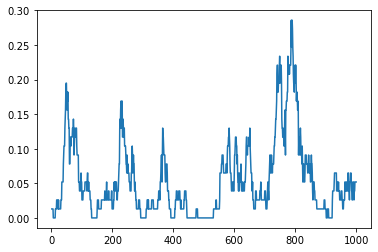

In [29]:
G = nx.les_miserables_graph()

model = CompartmentalModel(G, CompartmentalAgent, p_infected = 0.01,  F = F_SIS, beta = 0.01, beta_background = 0.001, gamma = 0.1)

for i in range(1000):
    model.step()

report = model.collector.get_agent_vars_dataframe().reset_index()
report["is_I"] = report["State"] == "I"
percentages = report.groupby("Step")["is_I"].mean()
fig = plt.plot(percentages)

# Effect of Policy

Suppose now that we consider a decision-maker with the ability to reduce the rate of transmission through measures such as mask mandates, shelter-in-place orders, or similar measures. We're going to model this as saying that the decision-maker has the ability to control the transmission rate $\beta$. We're going to assume that they impose mitigation measures when they observe a rate of infection above a certain point, and remove these mitigation measures when they observe a rate of infection below a certain point. However, we're going to assume that their information is *lagged*: their most recent data is actually $k$ days in the past. We're going to study what the impact of $k$ is. 

The way we implement this behavior in code is by having the model *change* $\beta$ when it observes the (lagged) data telling it that this is possible. This requires only that we (a) store the possible values of $\beta$ as instance variables and (b) that we add some additional behavior to the model's `step()` method to toggle between the two of them. 

In [31]:
class CompartmentalModel(Model):

    # model setup
    def __init__(self, G, agent_class, p_infected = 0, beta_background = 0, beta_low = 0, beta_high = 1, threshold = 0.2, lag = 0, **kwargs):

        self.schedule = SimultaneousActivation(self) 
        self.grid = NetworkGrid(G)            
        self.beta = beta_high
        self.beta_low = beta_low
        self.beta_high = beta_high
        self.beta_background = beta_background
        self.threshold = threshold
        self.lag = lag
        self.history = []

        node_list = list(G.nodes)

        # place multiple agents, each with an initial opinion
        for i in range(len(node_list)):
            node = node_list[i]
            state = "I" if np.random.rand() < p_infected else "S"
            agent = agent_class(node, self, state, **kwargs)
            self.grid.place_agent(agent, node)
            self.schedule.add(agent)

        self.collector = DataCollector(
            agent_reporters = {
                "State" : lambda a: a.state
            }
        )

    def step(self):
        self.schedule.step()
        self.collector.collect(self)
        
        # collect the percentage of infected agents
        percentage_I = np.mean([a.state == "I" for a in self.schedule.agents])
        self.history.append(percentage_I)
        
        # decision-making to adjust the infection rate beta
        if len(self.history) > self.lag:
            if self.history[-(self.lag+1)] > self.threshold:
                self.beta = self.beta_low
            else:
                self.beta = self.beta_high

In [32]:
def experiment(lag):

    G = nx.les_miserables_graph()

    model = CompartmentalModel(G, CompartmentalAgent, p_infected = 0.01,  F = F_SIS, beta_low = 0.01, beta_high = 0.03, beta_background = 0.001, gamma = 0.1, threshold = 0.05, lag = lag)

    for i in range(500):
        model.step()

    report = model.collector.get_agent_vars_dataframe().reset_index()
    report["is_I"] = report["State"] == "I"
    percentages = report.groupby("Step")["is_I"].mean()
    return(percentages)

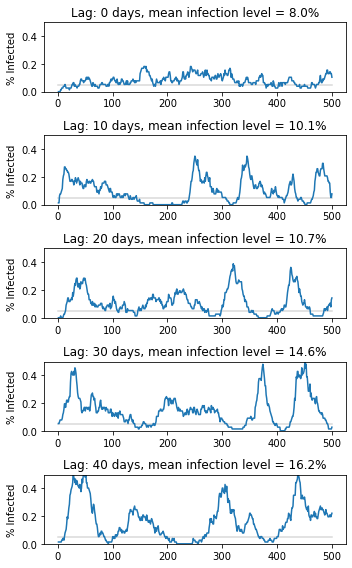

In [34]:
fig, axarr = plt.subplots(5, figsize = (5, 8))

lags = [0, 10, 20, 30, 40]

for i in range(5):
    percentages = experiment(lags[i])
    axarr[i].plot([0, 500], [0.05, 0.05], color = "grey", zorder = -10, alpha = 0.3)
    axarr[i].plot(percentages) 
    axarr[i].set_ylim([0, .5])
    mean_perc = np.round(100*np.mean(percentages), 1)
    axarr[i].set(title = f"Lag: {lags[i]} days, mean infection level = {mean_perc}%")
    axarr[i].set(ylabel = "% Infected")
plt.tight_layout()